<a href="https://colab.research.google.com/github/moonstar0301/Corn_Future_Prediction/blob/main/Hybrid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.vector_ar.vecm import VECM
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM


df = pd.read_excel('/content/drive/MyDrive/Fixed_Corn_Data.xlsx', index_col=0)
df

,NonComm_Positions_Long_All,WTI종가,달러화가치,옥수수선물_M1M,옥수수선물
Month,,,,,
1986-02-01,15882.50,13.26,115.150,244.75,227.00
1986-03-01,20370.00,10.42,118.080,227.00,230.75
1986-04-01,21457.50,13.34,112.620,230.75,232.75
1986-05-01,53892.50,14.30,117.650,232.75,200.50
1986-06-01,19210.00,12.78,112.050,200.50,184.00
...,...,...,...,...,...
2021-11-01,493028.40,66.18,96.007,568.25,567.00
2021-12-01,508236.00,75.21,95.593,567.00,593.25
2022-01-01,504919.25,88.15,96.537,593.25,626.00


In [ ]:
df.drop(['옥수수선물_M1M'], axis=1, inplace=True)
data = df
train_data = data.loc['2002-01':'2017-12']
test_data = data.loc['2018-01':'2021-12']

In [ ]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# 정규화
scaler = MinMaxScaler()
train_data_scaled = pd.DataFrame(scaler.fit_transform(train_data), 
                                 columns=train_data.columns, index=train_data.index)
test_data_scaled = pd.DataFrame(scaler.transform(test_data), 
                                columns=test_data.columns, index=test_data.index)

# cointegration test
johan_test_result = coint_johansen(train_data_scaled,-1,1)
traces = johan_test_result.lr1
crit_values = johan_test_result.cvt[:,1]

# 고유 벡터 계산
eigenvectors = johan_test_result.evec

# cointegration rank 결정
cointegration_rank = 0
for i in range(len(traces)):
    if traces[i] > crit_values[i]:
        cointegration_rank += 1
        
# VECM 모델 학습
model = VECM(train_data_scaled, k_ar_diff=2, coint_rank=cointegration_rank, deterministic="co")
vecm_fit = model.fit()

# test_data 예측
test_data_pred = vecm_fit.predict(steps=len(test_data_scaled))

# 정규화 된 예측값을 다시 원래 스케일로 되돌리기
test_data_pred = pd.DataFrame(scaler.inverse_transform(test_data_pred), 
                              columns=test_data.columns, index=test_data.index)

#test_data["옥수수선물"].values
#test_data_pred["옥수수선물"].values

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


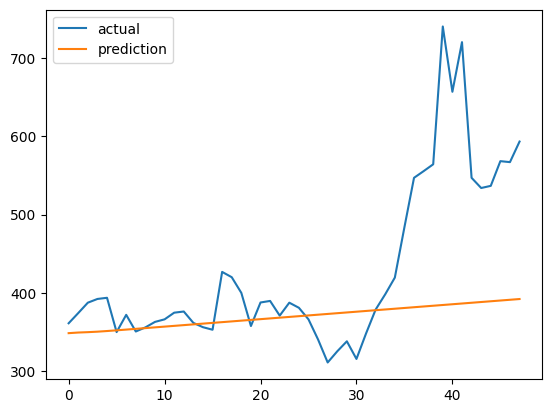

In [ ]:
import matplotlib.pyplot as plt
#test_mape = mape(y_test_actual, y_test_predicted)
plt.plot(test_data["옥수수선물"].values, label='actual')
plt.plot(test_data_pred["옥수수선물"].values, label='prediction')
plt.legend()
plt.show()

In [ ]:
VECM_test_data = test_data["옥수수선물"].values
VECM_pred_data = test_data_pred["옥수수선물"].values

In [ ]:
dif = VECM_pred_data[1] - VECM_pred_data[0]
a = VECM_pred_data[0] - dif
length = 192
arr = np.arange(a, a - dif * length, -dif)
arr = arr[::-1]

In [ ]:
dif_corn = train_data['옥수수선물'].values - arr

In [ ]:
df

,NonComm_Positions_Long_All,WTI종가,달러화가치,옥수수선물
Month,,,,
1986-02-01,15882.50,13.26,115.150,227.00
1986-03-01,20370.00,10.42,118.080,230.75
1986-04-01,21457.50,13.34,112.620,232.75
1986-05-01,53892.50,14.30,117.650,200.50
1986-06-01,19210.00,12.78,112.050,184.00
...,...,...,...,...
2021-11-01,493028.40,66.18,96.007,567.00
2021-12-01,508236.00,75.21,95.593,593.25
2022-01-01,504919.25,88.15,96.537,626.00


In [ ]:
# 훈련 데이터와 테스트 데이터로 분리
train_start, train_end = '2002-01', '2017-12'
test_start, test_end = '2018-01', '2021-12'
train = df.loc[train_start:train_end, :]
test = df.loc[test_start:test_end, :]

train['dif_corn'] = dif_corn
test['dif_corn'] = VECM_test_data-VECM_pred_data


<ipython-input-25-7cd6271f5752>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['dif_corn'] = dif_corn
<ipython-input-25-7cd6271f5752>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['dif_corn'] = VECM_test_data-VECM_pred_data


In [ ]:
train

,NonComm_Positions_Long_All,WTI종가,달러화가치,옥수수선물,dif_corn
Month,,,,,
2002-01-01,100274.75,19.48,120.590,213.00,17.447151
2002-02-01,91036.75,21.74,119.280,207.50,11.148525
2002-03-01,72378.00,26.31,119.060,209.00,11.849900
2002-04-01,66511.20,27.29,115.400,200.50,2.551275
2002-05-01,75927.50,25.31,111.910,220.50,21.752650
...,...,...,...,...,...
2017-08-01,392398.00,47.23,92.628,342.25,-2.645766
2017-09-01,375778.75,51.67,92.883,355.25,9.555608
2017-10-01,377928.00,54.38,94.429,345.75,-0.743017


In [ ]:

# 종속변수와 독립변수 나누기
X_train = train[['옥수수선물_M1M', 'WTI종가','달러화가치','NonComm_Positions_Long_All']]
y_train = train[['dif_corn']]
X_test = test[['옥수수선물_M1M', 'WTI종가','달러화가치','NonComm_Positions_Long_All']]
y_test = test[['dif_corn']]

# 스케일링
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

# 데이터 전처리
def create_dataset(X, y, time_steps=2):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:i+time_steps, :])
        ys.append(y[i+time_steps, 0])
    return np.array(Xs), np.array(ys)

time_steps=2

X_train_processed, y_train_processed = create_dataset(X_train_scaled, y_train_scaled, time_steps)
X_test_processed, y_test_processed = create_dataset(X_test_scaled, y_test_scaled, time_steps)

# 모델 학습
model = Sequential()
model.add(LSTM(units=10, input_shape=(time_steps, X_train_processed.shape[2])))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train_processed, y_train_processed, epochs=500, batch_size=20, verbose=1)

# 예측
y_train_predicted = model.predict(X_train_processed)
y_test_predicted = model.predict(X_test_processed)

# 스케일링 복원
y_train_predicted = scaler_y.inverse_transform(y_train_predicted)
y_test_predicted = scaler_y.inverse_transform(y_test_predicted)
y_train_actual = scaler_y.inverse_transform(y_train_processed.reshape(-1, 1))
y_test_actual = scaler_y.inverse_transform(y_test_processed.reshape(-1, 1))

#test_data["옥수수선물"].values
#test_data_pred["옥수수선물"].values

y_train_predicted = y_train_predicted + VECM_pred_data
y_test_actual = test_data["옥수수선물"].values

# MAPE 계산
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

test_mape = mape(y_test_actual, y_test_predicted)
print('Test MAPE:', test_mape)

<ipython-input-24-a55796838504>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['dif_corn'] = dif_corn
<ipython-input-24-a55796838504>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['dif_corn'] = VECM_test_data-VECM_pred_data


KeyError: ignored

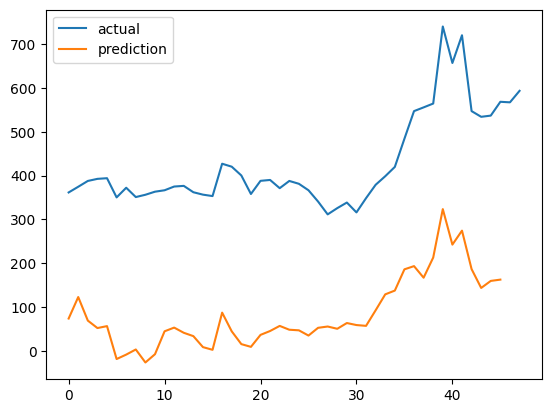

In [ ]:
import matplotlib.pyplot as plt
#test_mape = mape(y_test_actual, y_test_predicted)
plt.plot(y_test_actual, label='actual')
plt.plot(y_test_predicted, label='prediction')
plt.legend()
plt.show()